In [3]:
# this notebook is for testing when we smush 1Q gates into a 2Q gate (and changing its weyl coordinates)
# whether the new coordinates it gets access to gives the overall 2Q+smush additional volume had it not had otherwise

In [4]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
import numpy as np

%matplotlib widget

from slam.utils.visualize import unitary_2dlist_weyl, coordinate_2dlist_weyl
from qiskit.quantum_info import Operator
from weylchamber import c1c2c3
import h5py

# from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm

from config import srcpath

filename = f"{srcpath}/data/smush_unitary.h5"
from slam.utils.visualize import fpath_images

In [5]:
from slam.hamiltonian import ConversionGainPhaseHamiltonian
from slam.basisv2 import CircuitTemplateV2
from slam.utils.gates.custom_gates import ConversionGainGate

pp = lambda p1, p2: ConversionGainGate(p1, p2, np.pi / 4, np.pi / 4)
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp], no_exterior_1q=0, vz_only=1)
basis.build(1)

In [6]:
# what is volume of 1.5 iswaps with smushed gates, vs 3 sqrts with out
# can we make 1.8 pulse to 1.5 for swap

In [7]:
t = 1.5
duration_1q = 0.25
gc = 1 * np.pi / 2
gg = 0 * np.pi / 4
bounds_1q = 2 * np.pi

# First we twirl 1Q gates, gc and gg are given as parameters

In [8]:
# from slam.utils.gates.custom_gates import ConversionGainSmushGate

# # NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
# p_expand = [0, round(t/duration_1q), round(t/duration_1q)]
# # XXX turn p_expand into indices is tricky

# #pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], np.pi/2, 0, vargs[2:2+round(t/duration_1q)], vargs[2+round(t/duration_1q):], t_el=t)
# pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, gc, gg, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)
# # circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# # because the parametes for gx and gy are vectors they only get counted once and it messes up
# # we can add an extra parameter called param_vec_expand
# # we need to use this to tell it to expand the number of parameters we should include
# # however, this will get really messy because we don't know which parameters are the vectors or not
# # be careful, this is going to be a mess :(
# basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)
# basis.build(1)

# # #adding constraint of 1Q params need to be positive valued
# # #this could be optional let's compare what happens if include it or not
# # for el in basis.circuit.parameters:
# #     s_el = str(el)
# #     if 'Q' in s_el:
# #         basis.add_bound(s_el, bounds_1q, 0)
# # #basis.add_bound("Q0", 4*np.pi, 0)

# basis.circuit.draw(output='mpl')

In [7]:
# from slam.utils.visualize import unitary_2dlist_weyl
# from qiskit.quantum_info import Operator
# from tqdm import tqdm
# unitary_list = []
# param_list = []
# for i in tqdm(range(3000)):
#     params = basis.parameter_guess()
#     qc_init = basis.assign_Xk(params)
#     unitary_list.append(Operator(qc_init).data)
#     param_list.append(params)

# unitary_2dlist_weyl(unitary_list)

In [8]:
# coordinate_list = list(map(lambda x: c1c2c3(x), unitary_list))
# # combine the two lists
# combined_list = list(zip(coordinate_list, unitary_list, param_list))

# # arg min coordinate closest to (.75, 0, 0)
# sorted(combined_list, key=lambda x: np.linalg.norm(np.array(x[0]) - np.array([.75, 0,0])))[0][1]

# Second, we twirl 1Q gates and phase terms given the same gc,gg from (1)

In [13]:
from slam.utils.gates.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
poffset = 0
p_expand = [poffset, round(t / duration_1q), round(t / duration_1q)]
# XXX turn p_expand into indices is tricky

if poffset == 0:
    pp2 = lambda *vargs: ConversionGainSmushGate(
        0,
        0,
        gc,
        gg,
        vargs[: round(t / duration_1q)],
        vargs[round(t / duration_1q) :],
        t_el=t,
    )
else:
    pp2 = lambda *vargs: ConversionGainSmushGate(
        vargs[0],
        vargs[1],
        gc,
        gg,
        vargs[poffset : poffset + round(t / duration_1q)],
        vargs[poffset + round(t / duration_1q) :],
        t_el=t,
    )
# pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/du}ration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(
    n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand=p_expand
)
k = 1
basis.build(k)
# adding constraint of 1Q params need to be positive valued
# this could be optional let's compare what happens if include it or not
# for el in basis.circuit.parameters:
#     s_el = str(el)
#     if 'Q' in s_el:
#         basis.add_bound(s_el, bounds_1q, -bounds_1q)
# basis.add_bound("Q0", 4*np.pi, 0)
basis.circuit.draw()

┌───────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                  ├
     │  2qsmushgate(0,0,π/2,0,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,1.5) │
q_1: ┤1                                                                  ├
     └───────────────────────────────────────────────────────────────────┘

100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


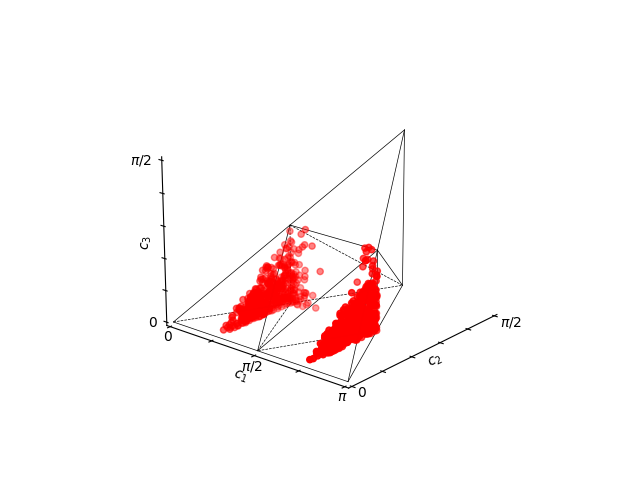

In [14]:
from slam.utils.visualize import unitary_2dlist_weyl
from qiskit.quantum_info import Operator
from tqdm import tqdm

# NOTE don't reset unitary list if want to stack between each K
unitary_list = []
# print(len(unitary_list))
# param_list = []

for i in tqdm(range(1000)):
    params = basis.parameter_guess()
    qc_init = basis.assign_Xk(params)
    unitary_list.append(Operator(qc_init).data)
    # param_list.append(params)

# get this case which should be the vanilla basis gate
params = np.array(basis.parameter_guess()) * 0
qc_init = basis.assign_Xk(params)
unitary_list.append(Operator(qc_init).data)
# param_list.append(params)

unitary_2dlist_weyl(unitary_list, c="red", no_bar=1)
coordinate_list = list(map(lambda x: c1c2c3(x), unitary_list))

In [179]:
# coordinate_2dlist_weyl(reduced_coordinate_list, no_bar=1);

In [175]:
# # combine the two lists
# combined_list = list(zip(coordinate_list, unitary_list, param_list))

# # arg min coordinate closest to (.5, .25, .25)
# sorted(combined_list, key=lambda x: np.linalg.norm(np.array(x[0]) - np.array([.5, .25, .25])))[0]

# # does same thing :)
# # idx  = np.argmin(np.linalg.norm(np.array(coordinate_list) - np.array([.5, .25, .25])))
# # print (coordinate_list[idx], unitary_list[idx])

# Next, we are generating points with a procedural step over gc and gg terms. 1Q and phase are twirled

In [11]:
from slam.utils.gates.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [4, round(t / duration_1q), round(t / duration_1q)]
# XXX turn p_expand into indices is tricky

# pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[4:4+round(t/duration_1q)], vargs[4+round(t/duration_1q):], t_el=t)
# #pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)


varg_offset = 2
pp2 = lambda *vargs: ConversionGainSmushGate(
    0,
    0,
    vargs[0],
    vargs[1],
    vargs[varg_offset : varg_offset + round(t / duration_1q)],
    vargs[varg_offset + round(t / duration_1q) :],
    t_el=t,
)
basis = CircuitTemplateV2(
    n_qubits=2,
    base_gates=[pp2],
    edge_params=[[(0, 1)]],
    vz_only=True,
    no_exterior_1q=1,
    param_vec_expand=[varg_offset, round(t / duration_1q), round(t / duration_1q)],
)
basis_str = "CG2Q"

# varg_offset = 4
# pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q+P"

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
# basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)
basis.build(1)
# adding constraint of 1Q params need to be positive valued
# this could be optional let's compare what happens if include it or not
for el in basis.circuit.parameters:
    s_el = str(el)
    if "Q" in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)
basis.circuit.draw()

»
q_0: »
     »
q_1: »
     »
«     ┌───────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                  ├
«     │  2qsmushgate(0,0,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,1) │
«q_1: ┤1                                                                                                  ├
«     └───────────────────────────────────────────────────────────────────────────────────────────────────┘

In [12]:
# #load from hdf5 file
# with h5py.File(filename, 'a') as f:
#     data = f.require_group(f'{basis_str}_unitary_cost_data_t{t}')
#     if 'unitary_list' in data and 'cost_list' in data:
#         unitary_list = list(data['unitary_list'][:])
#         cost_list = list(data['cost_list'][:])
#     else:
#         unitary_list = []
#         cost_list = []

unitary_list = []
cost_list = []
# outer loop is sweeping over gc and gc
for m in tqdm(np.linspace(0, 0.5, 11)):  # 17
    if m == 0:
        continue  # identity is not interesting case

    for n in np.linspace(0, 1, 9):  # 21
        for i in range(800):
            gc = n * m * np.pi
            gg = (1 - n) * m * np.pi
            cost = ConversionGainGate(0, 0, gc, gg, t_el=t).cost()

            # need to convert strings to Parameter objects
            # the reason need to do this is because need to get reference to the exact parameter object via iteration
            if basis_str == "CG2Q+P":
                pstrs = ["Q2", "Q3"]
            else:
                pstrs = ["Q0", "Q1"]

            pdict = {
                str(pstr): [p for p in basis.circuit.parameters if p.name == pstr][0]
                for pstr in pstrs
            }

            qc_init = basis.circuit.assign_parameters({pdict[pstrs[0]]: gc})
            qc_init = qc_init.assign_parameters({pdict[pstrs[1]]: gg})

            # randomize the remaining parameters
            # NOTE there isn't a 1-1 mapping from p to remaining parameters bc have replaced q2 and q3 already but doesnt matter since is random
            p = basis.parameter_guess()
            # qc_init = qc_init.assign_Xk(p)
            qc_init = qc_init.assign_parameters(
                {k: v for k, v in zip(qc_init.parameters, p)}
            )

            # eliminating x-axis symmetry
            c = list(c1c2c3(Operator(qc_init).data))
            if c[0] > 0.5:
                c[0] = -1 * c[0] + 1

            # #when checking for duplicates, keep the lower cost one
            # #instead of checking for duplicates, check if already a coordinate close by
            # if any([np.linalg.norm(np.array(c)-np.array(c2)) < 0.025 for c2 in unitary_list]):
            #     c2 = unitary_list[np.argmin([np.linalg.norm(np.array(c)-np.array(c2)) for c2 in unitary_list])]
            #     ind = unitary_list.index(c2)
            #     if cost < cost_list[ind]:
            #         unitary_list[ind] = c
            #         cost_list[ind] = cost
            #         continue
            else:
                unitary_list.append(c)
                cost_list.append(cost)

# do some preprocessing that takes the smaller cost value if their is a match of coordinates
# no not a good idea

# # save unitary list into a hdf5 file
# with h5py.File(filename, 'w') as f:
#     f.create_dataset(f'{basis_str}_unitary_cost_data_t{t}/unitary_list', data=unitary_list)
#     f.create_dataset(f'{basis_str}_unitary_cost_data_t{t}/cost_list', data=cost_list)

100%|██████████| 11/11 [1:25:30<00:00, 466.42s/it]


In [13]:
dub_unitary_list = []
dub_cost_list = []
for unitary, cost in zip(unitary_list, cost_list):
    # want to add the conjugate
    x, y, z = unitary
    dub_cost_list.append(cost)
    dub_unitary_list.append([x, y, z])
    dub_cost_list.append(cost)
    dub_unitary_list.append([1 - x, y, z])

In [1]:
fig = coordinate_2dlist_weyl(dub_unitary_list, c=dub_cost_list)
# save fig as pdf and svg
fig.savefig(f"{fpath_images}/smush_primative_sweep.svg", format="svg")
fig.savefig(f"{fpath_images}/smush_primative_sweep.pdf", format="pdf")

NameError: name 'coordinate_2dlist_weyl' is not defined

In [ ]:
# fill points on the triangle, interpolate
# and reflect over the axis

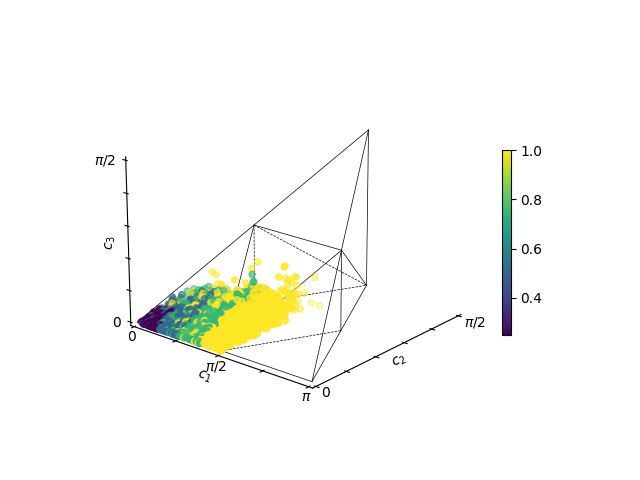

In [35]:
# load from hdf5 file
import h5py

with h5py.File(filename, "r") as f:
    data = f.require_group(f"{basis_str}_unitary_cost_data_t{t}")
    if "unitary_list" in data and "cost_list" in data:
        unitary_list = list(data["unitary_list"][:])
        cost_list = list(data["cost_list"][:])
fig = coordinate_2dlist_weyl(unitary_list, c=cost_list);

# #save fig to file as svg and as pdf
# fig.savefig(f'{fpath_images}/{basis_str}_unitary_cost_data_t{t}.svg', format='svg')
# fig.savefig(f'{fpath_images}/{basis_str}_unitary_cost_data_t{t}.pdf', format='pdf')

In [40]:
# #load from hdf5 file
# with h5py.File(filename, 'r') as f:
#     data = f.require_group('unitary_cost_data')
#     if 'unitary_list' in data and 'cost_list' in data:
#         unitary_list = list(data['unitary_list'][:])
#         cost_list = list(data['cost_list'][:])

# #if a coordinate is within some threshold of another coordinate, remove the one with the higher cost
# for i, (cost, c) in enumerate(zip(cost_list, unitary_list)):
#     #check if there is a coordinate within some threshold, not including itself
#     if any([np.linalg.norm(np.array(c)-np.array(c2)) < 0.025 for c2 in unitary_list if (c2 != c).all()]):
#         #if there is, find the index of the coordinate that is closest
#         c2 = unitary_list[np.argmin([np.linalg.norm(np.array(c)-np.array(c2)) for c2 in unitary_list if (c2 != c).all()])]
#         ind = np.where(np.all(unitary_list == c2, axis=1))[0][0]
#         #if the cost of the coordinate we are checking is higher, remove it
#         if cost > cost_list[ind]:
#             unitary_list.pop(i)
#             cost_list.pop(i)

# print(len(unitary_list))
# coordinate_2dlist_weyl(unitary_list, c=cost_list)

# Third, twirl all parameters. Unlike (3) with procedurally stepping gc and gg we guarantee the cost of gates is evenly distributed between [0,1]. If we twirl the gc and gg I want to see if there is more volume when the cost exceeds 1.

In [20]:
from slam.utils.gates.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [2, round(t / duration_1q), round(t / duration_1q)]
# XXX turn p_expand into indices is tricky

# pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, vargs[0], vargs[1], vargs[4:4+round(t/duration_1q)], vargs[4+round(t/duration_1q):], t_el=t)
# #pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)


varg_offset = 2
pp2 = lambda *vargs: ConversionGainSmushGate(
    0,
    0,
    vargs[0],
    vargs[1],
    vargs[varg_offset : varg_offset + round(t / duration_1q)],
    vargs[varg_offset + round(t / duration_1q) :],
    t_el=t,
)
basis = CircuitTemplateV2(
    n_qubits=2,
    base_gates=[pp2],
    edge_params=[[(0, 1)]],
    vz_only=True,
    param_vec_expand=[varg_offset, round(t / duration_1q), round(t / duration_1q)],
)
basis_str = "CG2Q"

# varg_offset = 4
# pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q+P"


# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(
    n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand=p_expand
)
basis.build(1)
# adding constraint of 1Q params need to be positive valued
# this could be optional let's compare what happens if include it or not
for el in basis.circuit.parameters:
    s_el = str(el)
    if "Q" in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)
# basis.add_bound("Q0", 4*np.pi, 0)
basis.circuit.draw()

»
q_0: »
     »
q_1: »
     »
«     ┌───────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                  ├
«     │  2qsmushgate(0,0,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,1) │
«q_1: ┤1                                                                                                  ├
«     └───────────────────────────────────────────────────────────────────────────────────────────────────┘

100%|██████████| 2500/2500 [04:54<00:00,  8.48it/s]


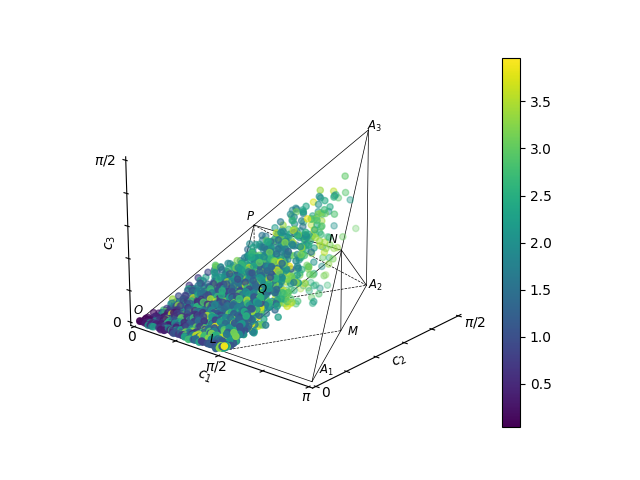

In [68]:
from slam.utils.visualize import unitary_2dlist_weyl, coordinate_2dlist_weyl
from qiskit.quantum_info import Operator
from weylchamber import c1c2c3
from tqdm import tqdm
from random import random

unitary_list = []
cost_list = []


from slam.utils.visualize import unitary_2dlist_weyl
from qiskit.quantum_info import Operator
from tqdm import tqdm

unitary_list = []
cost_list = []
for i in tqdm(range(2500)):
    gc = random() * np.pi
    gg = random() * np.pi
    cost = ConversionGainGate(0, 0, gc, gg, t_el=t).cost()

    # need to convert strings to Parameter objects
    # the reason need to do this is because need to get reference to the exact parameter object via iteration
    pstrs = ["Q2", "Q3"]
    pdict = {
        str(pstr): [p for p in basis.circuit.parameters if p.name == pstr][0]
        for pstr in pstrs
    }

    qc_init = basis.circuit.assign_parameters({pdict["Q2"]: gc})
    qc_init = qc_init.assign_parameters({pdict["Q3"]: gg})
    # randomize the remaining parameters
    # NOTE there isn't a 1-1 mapping from p to remaining parameters bc have replaced q2 and q3 already but doesnt matter since is random
    p = basis.parameter_guess()
    # qc_init = qc_init.assign_Xk(p)
    qc_init = qc_init.assign_parameters({k: v for k, v in zip(qc_init.parameters, p)})

    c = list(c1c2c3(Operator(qc_init).data))

    # eliminating x-axis symmetry
    if c[0] > 0.5:
        c[0] = -1 * c[0] + 1
    if c in unitary_list:
        continue

    unitary_list.append(c)
    cost_list.append(cost)

coordinate_2dlist_weyl(unitary_list, c=cost_list);

# Fourth, procedurally stepping gc and gg with no 1Q twirling or phase

In [6]:
from slam.utils.gates.custom_gates import ConversionGainSmushGate, ConversionGainGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [2, 1, 1]
# XXX turn p_expand into indices is tricky

pp2 = lambda *vargs: ConversionGainGate(0, 0, vargs[0], vargs[1], t_el=1.0)
# pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(
    n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand=p_expand
)

# adding constraint of 1Q params need to be positive valued
# this could be optional let's compare what happens if include it or not
basis.build(1)
for el in basis.circuit.parameters:
    s_el = str(el)
    if "Q" in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)

# basis.add_bound("Q0", 4*np.pi, 0)
basis.circuit.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  2qgate(0,0,Q0,Q1,1) │
q_1: ┤1                     ├
     └──────────────────────┘

100%|██████████| 47/47 [00:14<00:00,  3.29it/s]


3854


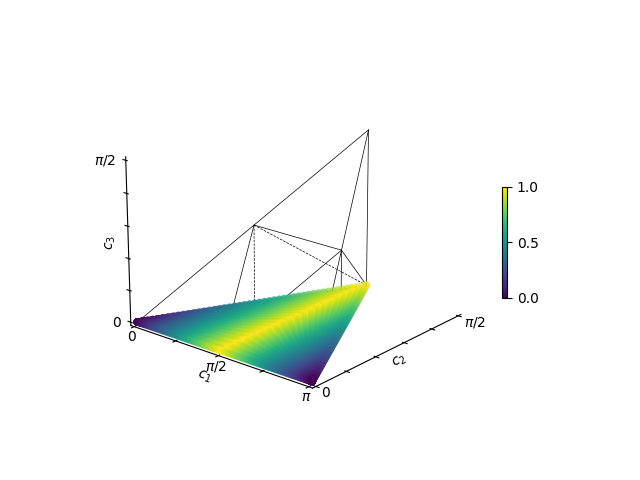

In [15]:
from slam.utils.visualize import unitary_2dlist_weyl, coordinate_2dlist_weyl
from qiskit.quantum_info import Operator
from weylchamber import c1c2c3
from tqdm import tqdm

unitary_list = []
cost_list = []

# outer loop is sweeping over gc and gc
for m in tqdm(np.linspace(0, 0.5, 47)):  # 47
    for n in np.linspace(0, 1, 41):  # 41
        for i in range(1):
            gc = n * m * np.pi
            gg = (1 - n) * m * np.pi
            cost = ConversionGainGate(0, 0, gc, gg, t_el=t).cost()

            # need to convert strings to Parameter objects
            # the reason need to do this is because need to get reference to the exact parameter object via iteration
            pstrs = ["Q0", "Q1"]
            pdict = {
                str(pstr): [p for p in basis.circuit.parameters if p.name == pstr][0]
                for pstr in pstrs
            }

            qc_init = basis.circuit.assign_parameters({pdict["Q0"]: gc})
            qc_init = qc_init.assign_parameters({pdict["Q1"]: gg})
            # randomize the remaining parameters
            # p = basis.parameter_guess()
            # qc_init = qc_init.assign_Xk(p)

            # eliminating x-axis symmetry
            c = list(c1c2c3(Operator(qc_init).data))
            unitary_list.append(c)
            cost_list.append(cost)

            # add the conjugate
            c_copy = c.copy()
            if c_copy[0] > 0.5:
                c_copy[0] = -1 * c_copy[0] + 1
            elif c_copy[0] < 0.5:
                c_copy[0] = 1 - c_copy[0]
            unitary_list.append(c_copy)
            cost_list.append(cost)

# do some preprocessing that takes the smaller cost value if their is a match of coordinates
# no not a good idea

coordinate_2dlist_weyl(unitary_list, c=cost_list)
print(len(unitary_list))

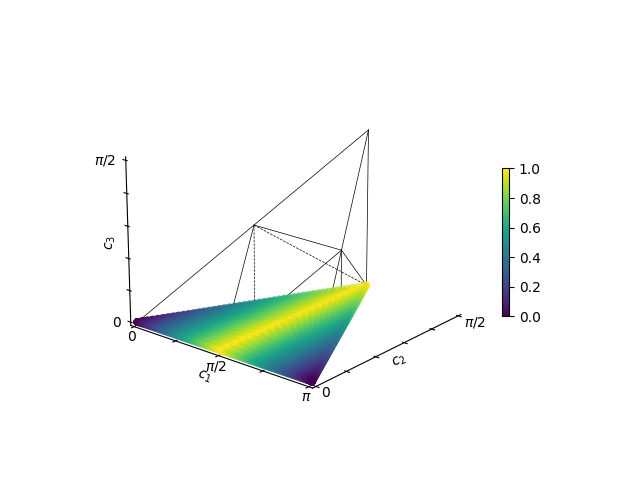

In [18]:
fig = coordinate_2dlist_weyl(unitary_list, c=cost_list)
# save fig as pdfpath_images svg
from slam.utils.visualize import fpath_images

fig.savefig(f"{fpath_images}/candidate_costs.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"{fpath_images}/candidate_costs.svg", format="svg", bbox_inches="tight")

1458


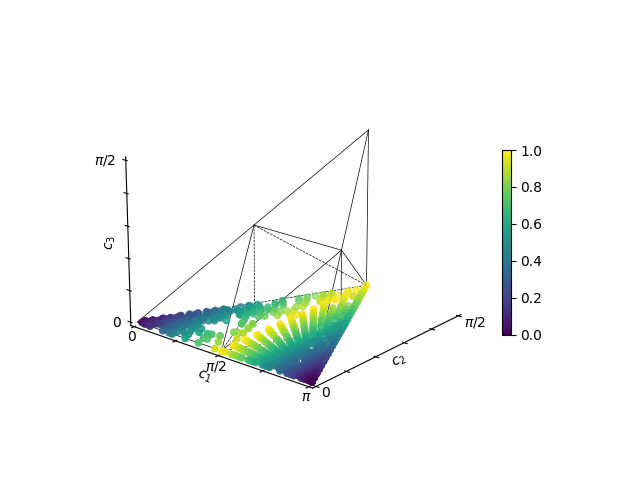

In [12]:
# if a coordinate is within some threshold of another coordinate, remove the one with the higher cost
for i, (cost, c) in enumerate(zip(cost_list, unitary_list)):
    # check if there is a coordinate within some threshold, not including itself
    if any(
        [
            np.linalg.norm(np.array(c) - np.array(c2)) < 0.1
            for c2 in unitary_list
            if (np.array(c2) != np.array(c)).all()
        ]
    ):
        # if there is, find the index of the coordinate that is closest
        c2 = unitary_list[
            np.argmin(
                [
                    np.linalg.norm(np.array(c) - np.array(c2))
                    for c2 in unitary_list
                    if (c2 != c).all()
                ]
            )
        ]
        ind = np.where(np.all(unitary_list == c2, axis=1))[0][0]
        # if the cost of the coordinate we are checking is higher, remove it
        if cost > cost_list[ind]:
            unitary_list.pop(i)
            cost_list.pop(i)

print(len(unitary_list))
coordinate_2dlist_weyl(unitary_list, c=cost_list);